In [ ]:
# Install MALLET 2.0.8RC3 from the official site
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8RC3.zip -O ~/mallet-2.0.8RC3.zip

# Unzip MALLET
!unzip ~/mallet-2.0.8RC3.zip -d ~/
!rm ~/mallet-2.0.8RC3.zip

# Rename the folder for convenience
!mv ~/mallet-2.0.8RC3 ~/mallet-2.0.8

# Define the path to the "mallet" binary
import os
mallet_dir = os.path.expanduser('~/mallet-2.0.8')
path_to_mallet = os.path.join(mallet_dir, 'bin', 'mallet')
print(f"Path to MALLET: {path_to_mallet}")

# Optionally check Java version
!java -version

In [ ]:
!pip install little_mallet_wrapper openpyxl

In [1]:
# -*- coding: utf-8 -*-
"""
Integrated script for MALLET-based topic modeling with per-file Fisher’s Exact
filtering and stopword exclusion. UTF-8 friendly.
Outputs:
  - Topic keys
  - Per-document topic distributions
  - Excel workbook with:
      • Topic tokens
      • Token counts per document
      • Topic probabilities per document
  - Separate Excel workbook with top-document titles per topic

Graphical output (heatmap & boxplots) is disabled in this pipeline.
See plotting_helpers.py for on-demand plotting.
"""


import os
import csv
import time
from pathlib import Path
from collections import Counter

import pandas as pd
from scipy.stats import fisher_exact
import little_mallet_wrapper
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import pickle

# Change this path to point to the local MALLET binary in the current directory.
# For example, place the mallet-2.0.8 folder in the same directory as this script.
# Then use os.path.join(...) relative to the current working directory (codespace).
mallet_dir = os.path.expanduser('~/mallet-2.0.8')
path_to_mallet = os.path.join(mallet_dir, 'bin', 'mallet')

# These will be set by main() and picked up by plotting_helpers.py
OUTPUT_DIR = None
NUM_TOPICS = None

def tokenize_file(filepath):
    """Load a UTF-8 text file and split on whitespace (preserves accents)."""
    with open(filepath, "r", encoding="utf-8") as f:
        return f.read().split()

def list_txt_files(directory):
    """Return a sorted list of all .txt filenames in a directory."""
    return sorted(fn for fn in os.listdir(directory) if fn.endswith(".txt"))

def list_csv_files(directory):
    """
    Recursively find all .csv files under a directory, skipping
    any .ipynb_checkpoints folders.
    """
    csv_paths = []
    for root, dirs, files in os.walk(directory):
        if ".ipynb_checkpoints" in dirs:
            dirs.remove(".ipynb_checkpoints")
        for fn in files:
            if fn.lower().endswith(".csv"):
                csv_paths.append(os.path.join(root, fn))
    return csv_paths

def choose_directory(prompt):
    """
    Display a numbered list of immediate subdirectories (plus current dir)
    and return the full path selected by the user.
    """
    cwd = os.getcwd()
    base = Path(cwd).name
    subdirs = [
        d for d in os.listdir(cwd)
        if os.path.isdir(os.path.join(cwd, d)) and d != ".ipynb_checkpoints"
    ]
    options = [(os.path.join(cwd, d), f"{base}/{d}") for d in subdirs]
    options.append((cwd, base))

    print(prompt)
    for i, (_, label) in enumerate(options, start=1):
        print(f"{i}. {label}")

    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(options):
                return options[choice - 1][0]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

def choose_files(filenames):
    """
    Let user pick one or more filenames by:
      - indices ("2" or "1,3")
      - index ranges ("1-4")
      - prefix matching ("report")
      - or the keyword "all" to select every file.
    Returns a sorted, unique list of chosen filenames.
    """
    print("Available files:")
    for i, fn in enumerate(filenames, start=1):
        print(f"{i}. {fn}")
    choice = input("Select files (indices, ranges, prefix, or 'all'): ").strip().lower()

    if choice == "all":
        return filenames.copy()

    selected = []
    for part in choice.split(","):
        part = part.strip()
        if part == "all":
            return filenames.copy()
        if "-" in part:
            a, b = map(int, part.split("-"))
            selected.extend(filenames[a - 1:b])
        elif part.isdigit():
            selected.append(filenames[int(part) - 1])
        else:
            selected.extend(fn for fn in filenames if fn.startswith(part))
    return sorted(set(selected))

def choose_csv_file(csv_paths):
    """
    Prompt the user to select one CSV from a list of paths.
    Returns the chosen filepath.
    """
    cwd = os.getcwd()
    base = Path(cwd).name
    print("Select your stopwords CSV:")
    for i, full in enumerate(csv_paths, start=1):
        rel = os.path.relpath(full, cwd)
        print(f"{i}. {base}/{rel}")

    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(csv_paths):
                return csv_paths[choice - 1]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

def read_stopwords(filepath):
    """Load stopwords from a CSV, splitting on commas and trimming whitespace."""
    sw = []
    with open(filepath, "r", encoding="utf-8") as f:
        for row in csv.reader(f):
            for cell in row:
                sw.extend(cell.split(","))
    return [w.strip() for w in sw if w.strip()]

def get_fishers(word, freq_dict, rate_dict, alternative="greater"):
    """
    Perform Fisher’s Exact Test on one token:
        [[observed, total-observed],
         [expected, total-expected]]
    Returns the p-value.
    """
    observed = freq_dict.get(word, 0)
    total = sum(freq_dict.values())
    expected = round(rate_dict.get(word, 0) * total)
    table = [
        [observed, total - observed],
        [expected, total - expected]
    ]
    _, pval = fisher_exact(table, alternative=alternative)
    return pval

def calculate_rate_dictionary(rate_files, rate_dir):
    """
    Build a background rate dictionary from reference documents.
    Returns a mapping { token: relative_frequency }.
    """
    counter = Counter()
    total_tokens = 0
    for fn in rate_files:
        tokens = tokenize_file(os.path.join(rate_dir, fn))
        counter.update(tokens)
        total_tokens += len(tokens)
    return {tok: cnt / total_tokens for tok, cnt in counter.items()}

def prepare_training_data(files, directory, stopwords, rate_dict, alpha):
    """
    For each file:
      1. Tokenize and count every token.
      2. Exclude stopwords and tokens with Fisher p-value ≥ alpha.
      3. Collect filtered document text and raw token counts.
    Prints per-file progress with elapsed time.
    Returns:
      - docs: list of filtered document strings for MALLET input
      - distributions: list of Counter objects of raw token counts
    """
    docs = []
    distributions = []
    total = len(files)
    overall_start = time.time()

    for idx, fn in enumerate(files, start=1):
        file_start = time.time()
        print(f"[{idx}/{total}] ⏳ Processing '{fn}'... ")

        path = os.path.join(directory, fn)
        tokens = tokenize_file(path)
        freq = Counter(tokens)

        filtered = [
            w for w in tokens
            if w not in stopwords and get_fishers(w, freq, rate_dict) < alpha
        ]
        docs.append(" ".join(filtered))
        distributions.append(freq)

        elapsed = time.time() - file_start
        kept = len(filtered)
        before = len(tokens)
        pct = (kept / before * 100) if before else 0
        print(f"done in {elapsed:.1f}s – kept {kept}/{before} tokens ({pct:.1f}%).")

    total_elapsed = time.time() - overall_start
    print(f"[Done] Prepared {total} documents in {total_elapsed:.1f}s.\n")
    return docs, distributions

def train_topic_model(training_docs, num_topics, output_dir):
    """
    Train a MALLET model via little_mallet_wrapper
    Returns:
      - topics: list of token lists (topic keys)
      - doc_topics: list of probability lists (per-document topic distributions)
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Make sure MALLET is installed and that path_to_mallet points to the local file in the codespace.
    little_mallet_wrapper.quick_train_topic_model(
        path_to_mallet,
        output_dir,
        num_topics,
        training_docs
    )

    key_file = os.path.join(output_dir, f"mallet.topic_keys.{num_topics}")
    topics = little_mallet_wrapper.load_topic_keys(key_file)

    dist_file = os.path.join(output_dir, f"mallet.topic_distributions.{num_topics}")
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)

    return topics, doc_topics

def save_results_to_excel(excel_path, topics, token_distributions, doc_topics, files):
    """
    Create an Excel workbook with:
      1) 'Topics' sheet: one row per topic (Topic#, top tokens...)
      2) One sheet per document: raw token counts (removing '_stemmed' suffix)
      3) 'DocTopicDist' sheet: topic probabilities per document
    """
    wb = Workbook()
    ws0 = wb.active
    ws0.title = "Topics"
    for idx, topic in enumerate(topics):
        ws0.append([f"Topic {idx}"] + topic)

    for fn, dist in zip(files, token_distributions):
        sheet_name = Path(fn).stem.replace("_stemmed", "")
        sheet = wb.create_sheet(title=sheet_name)
        df = pd.DataFrame.from_dict(dist, orient="index", columns=["count"])
        for row in dataframe_to_rows(df, index=True, header=True):
            sheet.append(row)

    ws3 = wb.create_sheet(title="DocTopicDist")
    header = ["Document"] + [f"Topic{t}" for t in range(len(topics))]
    ws3.append(header)
    for fn, probs in zip(files, doc_topics):
        doc_name = Path(fn).stem.replace("_stemmed", "")
        ws3.append([doc_name] + [round(p, 4) for p in probs])

    wb.save(excel_path)

def save_top_titles_excel(xlsx_path, topics, training_docs, doc_topics, doc_titles, n_docs):
    """
    Save the top n_docs document titles per topic into an Excel file,
    one sheet per topic named 'Topic{#}', and remove the default blank sheet.
    """
    wb = Workbook()
    default_sheet = wb.active
    wb.remove(default_sheet)

    for t_idx in range(len(topics)):
        ws = wb.create_sheet(title=f"Topic{t_idx}")
        ws.append(["Probability", "Document Title"])
        for prob, doc in little_mallet_wrapper.get_top_docs(
            training_docs, doc_topics, t_idx, n=n_docs
        ):
            title = doc_titles.get(doc, Path(doc).stem)
            ws.append([round(prob, 4), title])

    wb.save(xlsx_path)

def input_float(prompt, min_val=None, max_val=None, default=None):
    """Prompt until the user enters a valid float (and optionally within range)."""
    while True:
        # Add default value to prompt if it exists
        if default is not None:
            prompt_with_default = f"{prompt} [default: {default}] "
        else:
            prompt_with_default = prompt
        
        resp = input(prompt_with_default).strip()
        
        # Return default if response is empty
        if not resp and default is not None:
            return default
            
        try:
            val = float(resp)
            if min_val is not None and val < min_val:
                print(f"Value must be at least {min_val}.")
                continue
            if max_val is not None and val > max_val:
                print(f"Value must be at most {max_val}.")
                continue
            return val
        except ValueError:
            print("Invalid input, please enter a valid number.")

def input_int(prompt, min_val=None, max_val=None):
    """Prompt until the user enters a valid integer (and optionally within range)."""
    while True:
        resp = input(prompt).strip()
        try:
            val = int(resp)
            if min_val is not None and val < min_val:
                print(f"Value must be at least {min_val}.")
                continue
            if max_val is not None and val > max_val:
                print(f"Value must be at most {max_val}.")
                continue
            return val
        except ValueError:
            print("Invalid input, please enter a valid integer.")

def main():
    global OUTPUT_DIR, NUM_TOPICS

    # Prompt user: reuse preprocessed data or run full pipeline
    reuse = input("Reuse preprocessed data? (y/n): ").strip().lower()
    if reuse == 'y':
        # Enumerate possible folders containing preprocessed data
        cwd = os.getcwd()
        # List all subdirectories in cwd that contain 'preprocessed_docs.pkl'
        candidates = []
        for d in os.listdir(cwd):
            full_path = os.path.join(cwd, d)
            if os.path.isdir(full_path):
                pkl_path = os.path.join(full_path, "preprocessed_docs.pkl")
                if os.path.exists(pkl_path):
                    candidates.append(d)
        if not candidates:
            print("No folders with preprocessed data found in this directory.")
            return
        print("Select a folder containing preprocessed data:")
        for i, d in enumerate(candidates, start=1):
            print(f"{i}. {d}")
        while True:
            try:
                choice = int(input("Enter number: ").strip())
                if 1 <= choice <= len(candidates):
                    pre_dir = candidates[choice - 1]
                    break
            except ValueError:
                pass
            print("Invalid choice, please try again.")
        OUTPUT_DIR = os.path.join(cwd, pre_dir)
        with open(os.path.join(OUTPUT_DIR, "preprocessed_docs.pkl"), "rb") as f:
            training_docs, token_distributions, target_files = pickle.load(f)
        print(f"Loaded preprocessed data from {OUTPUT_DIR}.")
    else:
        # 1) Choose and load stopwords CSV
        stop_csv = choose_csv_file(list_csv_files(os.getcwd()))
        stopwords = read_stopwords(stop_csv)

        # 2) Build background rate dictionary
        rate_dir = choose_directory("Select reference text directory:")
        rate_files = choose_files(list_txt_files(rate_dir))
        rate_dict = calculate_rate_dictionary(rate_files, rate_dir)

        # 3) Select target files
        target_dir = choose_directory("Select target text directory:")
        target_files = choose_files(list_txt_files(target_dir))

        # 4) Output folder
        while True:
            out_sub = input("Enter name for output folder: ").strip()
            if out_sub:
                break
            print("Output folder name cannot be empty.")
        OUTPUT_DIR = os.path.join(os.getcwd(), out_sub)
        Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

        # 5) Fisher’s Exact threshold
        alpha = input_float(
            "Enter Fisher’s Exact alpha threshold:",
            min_val=0.0, max_val=1.0, default=0.05
        )

        # 6) Prepare filtered training data
        training_docs, token_distributions = prepare_training_data(
            target_files, target_dir, stopwords, rate_dict, alpha
        )

        # 7) Save preprocessed data for reuse
        with open(os.path.join(OUTPUT_DIR, "preprocessed_docs.pkl"), "wb") as f:
            pickle.dump((training_docs, token_distributions, target_files), f)
        print(f"Preprocessed data saved to {OUTPUT_DIR}.")

    # Prompt for one or more numbers of topics
    topic_str = input("Enter number(s) of topics to generate (e.g., 10, 20-23, 30): ").strip()
    topic_nums = []
    for part in topic_str.split(','):
        part = part.strip()
        if '-' in part:
            try:
                start, end = map(int, part.split('-'))
                if start <= end:
                    topic_nums.extend(range(start, end + 1))
                else:
                    # Handle case where user enters range in reverse order
                    topic_nums.extend(range(end, start + 1))
            except ValueError:
                print(f"Ignoring invalid range: '{part}'")
        elif part.isdigit():
            topic_nums.append(int(part))
            
    topic_nums = sorted(list(set(topic_nums))) # Remove duplicates and sort

    if not topic_nums:
        print("No valid topic numbers entered. Exiting.")
        return

    # Prompt for number of top documents per topic
    n_top_docs = input_int("Enter number of top documents per topic: ", min_val=1)
    for num_topics in topic_nums:
        print(f"\n--- Training topic model with {num_topics} topics ---")
        NUM_TOPICS = num_topics
        run_dir = os.path.join(OUTPUT_DIR, f"topics_{num_topics}")
        Path(run_dir).mkdir(parents=True, exist_ok=True)
        topics, doc_topics = train_topic_model(training_docs, NUM_TOPICS, run_dir)
        fn_list_path = os.path.join(run_dir, "input_filenames.txt")
        with open(fn_list_path, "w", encoding="utf-8") as f:
            for fn in target_files:
                f.write(fn + "\n")
        excel_results = os.path.join(run_dir, "topic_model_results.xlsx")
        save_results_to_excel(excel_results, topics, token_distributions, doc_topics, target_files)
        doc_titles = {doc: Path(fn).stem for doc, fn in zip(training_docs, target_files)}
        top_titles_path = os.path.join(run_dir, "top_titles.xlsx")
        save_top_titles_excel(
            top_titles_path, topics, training_docs, doc_topics, doc_titles, n_top_docs
        )
        print(f"✅ Finished {num_topics} topics. Results in {run_dir}.")
    print("\nAll requested topic models completed!")
    print("To create heatmaps or boxplots, import and run plotting_helpers.generate_heatmap() or generate_boxplots().")

if __name__ == "__main__":
    main()

Select your stopwords CSV:
1. lemmatized/stop_words.csv
Select reference text directory:
1. lemmatized/Concatenated
2. lemmatized
Available files:
1. Discours des raisons_corrected_stemmed.txt
2. Démonomanie Repair_corrected_stemmed.txt
3. Harangue - Fontainebleau_corrected_stemmed.txt
4. Harangue - Orléans 2_corrected_stemmed.txt
5. Harangue - Orléans_corrected_stemmed.txt
6. Harangue - Poissy_corrected_stemmed.txt
7. Harangue - Rouen_corrected_stemmed.txt
8. Harangue - Saint Germain_corrected_stemmed.txt
9. Harangue - lit de justice_corrected_stemmed.txt
10. Harangue - ouverture de parlement_corrected_stemmed.txt
11. Harangue - parlement 2_corrected_stemmed.txt
12. Harangue - parlement 3_corrected_stemmed.txt
13. Harangue - parlement_corrected_stemmed.txt
14. Harangue - religion_corrected_stemmed.txt
15. Harangue - septembre_corrected_stemmed.txt
16. La réponse_corrected_stemmed.txt
17. Le paradoxe_corrected_stemmed.txt
18. Lettre_corrected_stemmed.txt
19. Lit de justice_corrected_st

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.35169
<20> LL/token: -6.10976
<30> LL/token: -6.05688
<40> LL/token: -6.02564

0	0.625	veu roy sujet don guerr estat conseil ennemy arme édict enfant paix marqu libert couron consul besoin pareil chef estranger 
1	0.625	bien princ peupl republ loi puissanc magistrat empereur souverain romain plusieur peu populair droit ancien vill entre seigneur doit senat 
2	0.625	bien dieu vertu chos peupl homm prix deni demy sous escus pay mal donc beaucoup peu vic fin raison aristot 
3	0.625	roy estat duc franc charl royaum pay lettr seigneur vill don hommag droit philipp entre paix domain maistr ordon arrest 
4	0.625	dieu sorci comt diabl veu homm mort esprit sathan moyen jour deput malin terr cas traict jean fill mot confess 
5	0.625	chos corp fort natur ame terr eau fois caus form animal fin mond soleil air appel mouv forc feu naturel 
6	0.625	part raison mer plant best long e

Complete


/usr/local/python/3.12.1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


✅ Finished 8 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_8.

--- Training topic model with 9 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.35169
<20> LL/token: -6.12075
<30> LL/token: -6.00798
<40> LL/token: -5.9658

0	0.55556	bien prix peupl pay deni peu monnoy lou franc marc escus ital fol argent souverain prof vassal veniz attendu affin 
1	0.55556	caus raison cert lign engendr espec anné grandeur lumier proport peur mont facil comment cor cieux aliment clair cœur aim 
2	0.55556	roy estat comt duc franc jour charl deput terr pay royaum traict jean don hommag religion seigneur paix droit lettr 
3	0.55556	chos corp fort natur ame part terr eau fois form animal fin mond soleil air appel mouv forc feu naturel 
4	0.55556	justic bien bon jug homm réform temp injustic honneur public gen proc charg party sort mal vertu conseil offic court 
5	0.55556	roy sujet veu loi don seigneur vill entre guerr ordon doit pay princ gard enfant conseil royaum arme pap charl 
6	0.55556	dieu sorci diabl homm veu esprit mort s

Complete
✅ Finished 9 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_9.

--- Training topic model with 10 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.33783
<20> LL/token: -6.06324
<30> LL/token: -5.97623
<40> LL/token: -5.94011

0	0.5	corp fort natur ame part terr eau fois caus form animal mond soleil air appel mouv forc feu naturel matier 
1	0.5	proc charg raison corrupt propr sag genr magistrat pein rayon dignit compaign assembl épice gouvern person occident expliqu suffis honor 
2	0.5	roy estat comt duc franc charl jour terr pay traict jean don hommag droit seigneur lettr entre vill paris duch 
3	0.5	roy estat veu royaum guerr ordon don sujet conseil gard vill seigneur arme maison paix souverainet loi édict ennemy citoyen 
4	0.5	sorci dieu diabl veu homm mort esprit sathan moyen malin mot confess pein enfant mer femm cas certain malad vérit 
5	0.5	bien princ republ peupl loi puissanc magistrat estat empereur sujet souverain romain droit entre plusieur populair ancien doit senat empir 
6	0.5	justic bien bon ju

Complete
✅ Finished 10 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_10.

--- Training topic model with 11 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.35204
<20> LL/token: -6.10642
<30> LL/token: -5.99632
<40> LL/token: -5.94844

0	0.45455	peupl princ peu honneur prix gard pay arme rom deni esclav franc ordinair maiest dessus monnoy nobl marc faisoit gouvern 
1	0.45455	comt duc terr traict jean duch sainct baill paris frer trent quar mariaig charl bretaign sieur dauphin lorrain ressort accord 
2	0.45455	bien homm vertu mal conseil raison injustic viv ruin tort amour divin outraig injur vic nécessair miser consider pauvr heureux 
3	0.45455	chos corp ame eau fois part fin animal mond soleil appel form fer aristot petit avon entend sembl pierr lun 
4	0.45455	roy estat seigneur don vill pay droit entre charl franc duc royaum pap lettr paix angleterr arrest maistr hommag cas 
5	0.45455	justic bon jug bien réform temp honneur public gen party proc charg court dieu sort homm injustic offic caus vérit 
6	0.45455	natur fo

Complete
✅ Finished 11 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_11.

--- Training topic model with 12 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.31995
<20> LL/token: -6.1435
<30> LL/token: -6.06896
<40> LL/token: -6.01826

0	0.41667	roy estat deput religion tier franc jour part royaum assembl bodin paix cayer assemble president nobless ordre amour articl celt 
1	0.41667	dieu sorci homm diabl veu mort esprit sathan moyen malin mot divin confess humain vérit malad pein enfant fill mer 
2	0.41667	republ bien princ sujet don royaum guerr estat magistrat ordon souverain roy plusieur senat puissanc conseil romain person entre empereur 
3	0.41667	roy loi estat bien princ veu republ seigneur puissanc droit vill ancien empereur sujet doit magistrat mort enfant populair romain 
4	0.41667	roy argent pay ordon court royaum duch baill escus monnoy frer sous chanceli veu deni prix vill seigneur lorrain gard 
5	0.41667	justic bien homm réform bon injustic honneur public vertu sort gen princ mal sainct vray pauvr ruin méri

Complete
✅ Finished 12 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_12.

--- Training topic model with 13 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.37104
<20> LL/token: -6.09349
<30> LL/token: -5.99889
<40> LL/token: -5.94846

0	0.38462	roy estat deput paix royaum jean franc religion jour tier guerr sieur part party assembl domain ressort cayer assemble president 
1	0.38462	chos ame fin raison aristot sembl premier best infin sent ver ange tir couleur ailleur element accident lign espec lumier 
2	0.38462	jug justic bon bien temp proc charg party court réform offic honneur caus rend raison argent public praticqu avaric profict 
3	0.38462	bien justic homm bon vertu dieu réform injustic mal gen sort public princ vérit faveur honneur pauvr vray mérit jug 
4	0.38462	bien souverain charg peu mieux prix publiqu deni souvent civil necessair sais gouvern rich peupl marc empir philipp senateur tenu 
5	0.38462	roy ordon vill sujet gard don seigneur arme royaum ennemy pay loi couron chef maison libert maiest estranger per

Complete
✅ Finished 13 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_13.

--- Training topic model with 14 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.39933
<20> LL/token: -6.14129
<30> LL/token: -6.06564
<40> LL/token: -6.0125

0	0.35714	dieu sorci diabl veu homm mort esprit sathan moyen divin malin mot confess humain malad fill pein enfant femm vérit 
1	0.35714	bien estat pay puissanc peupl souverain republ person princ honneur magistrat charg peu rom vill command droit ancien mar arrest 
2	0.35714	roy estat franc jour deput terr jean royaum religion lettr paix tier sainct paris églis pay sieur part arrest mariaig 
3	0.35714	chos corp fort natur ame part terr eau fois caus form animal fin mond soleil air appel mouv forc raison 
4	0.35714	roy guerr don vill royaum sujet ennemy arme paix libert seigneur enfant philipp estranger maison chef couron maiest gard amend 
5	0.35714	conseil bien princ vertu peupl vic homm assembl estat royaum souverain aim raison volont amour gard prudenc fuiur aristot nouslifon 
6	0.357

Complete
✅ Finished 14 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_14.

--- Training topic model with 15 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.24194
<20> LL/token: -6.06207
<30> LL/token: -5.99548
<40> LL/token: -5.9691

0	0.33333	argent temp charg gen vray honneur proc peu sainct affair praticqu avaric conseil lor siecl present vénal estim dignit bel 
1	0.33333	quar quant sept mont origin bar renuerf cinqu royn guillaum appanaig pla lyon navarr ambassadeur récompens puill cardinal quitt prom 
2	0.33333	magistrat charg person bien qualit sag peu occasion craint cruaut commissair fuiu mour sujet particulier foient lig gift deflor cognoifl 
3	0.33333	sorci moyen fill enfant cas crim vérit proc histoir parol diet brûl remarqu detest disent cap faisoit marqu presompt best 
4	0.33333	forc mond mouv propr fond best terr ange grandeur celest arbre vient figur peur facil cor côté pourr degr tour 
5	0.33333	peupl prix pay deni peu franc monnoy marc escus rich fol contraint merit foix aisn diminu cftat grain entrel

Complete
✅ Finished 15 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_15.

--- Training topic model with 16 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 16 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 57944
total tokens: 131907
<10> LL/token: -6.3699
<20> LL/token: -6.18291
<30> LL/token: -6.09475
<40> LL/token: -6.03883

0	0.3125	roy duc estat conseil lettr entre court fief veu maistr royaum angleterr assembl europ expre royn édict sousl ressort request 
1	0.3125	roy estat deput religion tier paix franc guerr royaum jour homm don mal cayer assemble president nobless bodin arme ordre 
2	0.3125	roy bien estat pay seigneur magistrat guerr royaum charl don franc mieux arrest qualit chang arme general lou droit civil 
3	0.3125	appel feu ame fois terr pierr savoir diametr element donc lign froid celest fort dur liv lumier fin minut odeur 
4	0.3125	dieu sorci diabl homm veu mort esprit sathan moyen malin mot confess humain malad fill enfant mer femm cas certain 
5	0.3125	pein vérit crim proc brûl nomm faisoit sacrific presompt song croir vision impiet escriptur creatur meschancet demon violent malefic defendu 
6

Complete
✅ Finished 16 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Aug1725/topics_16.

All requested topic models completed!
To create heatmaps or boxplots, import and run plotting_helpers.generate_heatmap() or generate_boxplots().


Searching for topic model run directories...
Please select a run directory:
[1] July2725/topics_13
[2] July2725/topics_14
[3] July2725/topics_17
[4] July2725/topics_8
[5] July2725/topics_12
[6] July2725/topics_10
[7] July2725/topics_11
[8] July2725/topics_16
[9] July2725/topics_9
[10] July2725/topics_18
[11] July2725/topics_15
[12] August0425/topics_13
[13] August0425/topics_14
[14] August0425/topics_17
[15] August0425/topics_8
[16] August0425/topics_12
[17] August0425/topics_10
[18] August0425/topics_11
[19] August0425/topics_16
[20] August0425/topics_9
[21] August0425/topics_18
[22] August0425/topics_15
Successfully loaded run directory 'August0425/topics_8' with 8 topics.

Select which plots to generate:
1) Heatmap (PDF)
2) Boxplot grid (JPG)
3) LMW boxplots (PDF, label-based)
Type any combination of these numbers separated by commas (e.g. 1,2,3), or 'all' for all:


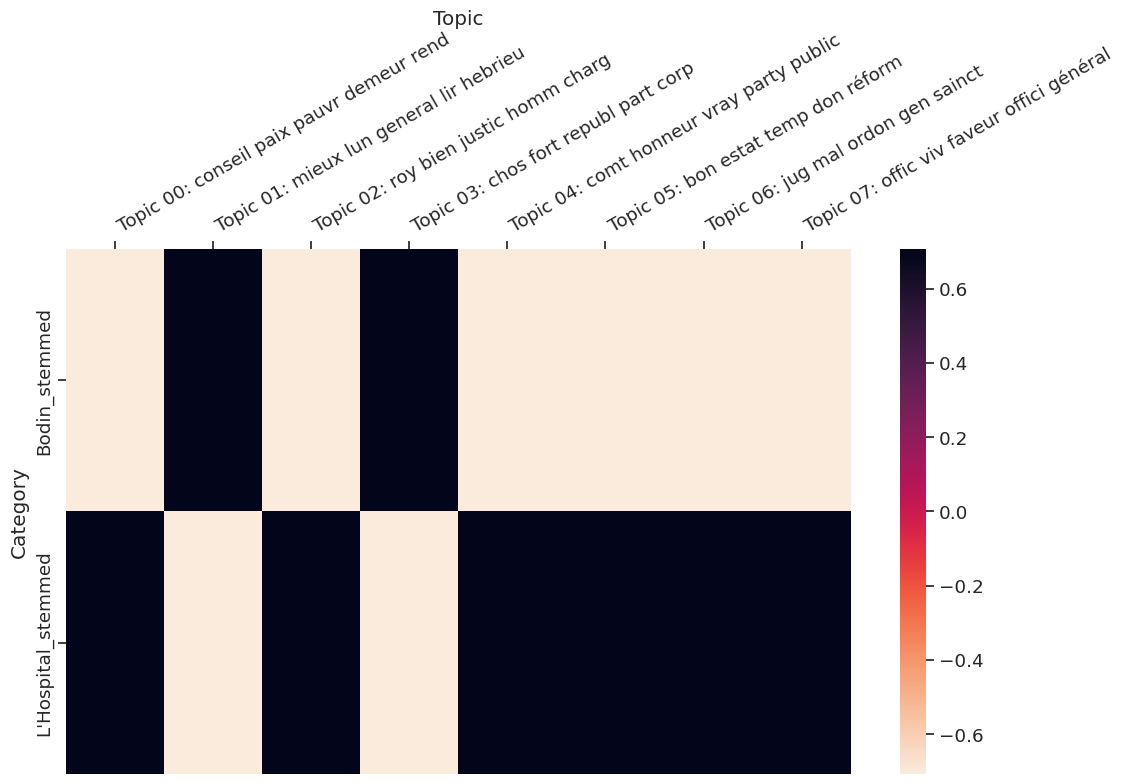

Heatmap saved: /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/categories_by_topics.pdf
Boxplot grid saved: /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/all_topic_boxplots.jpg


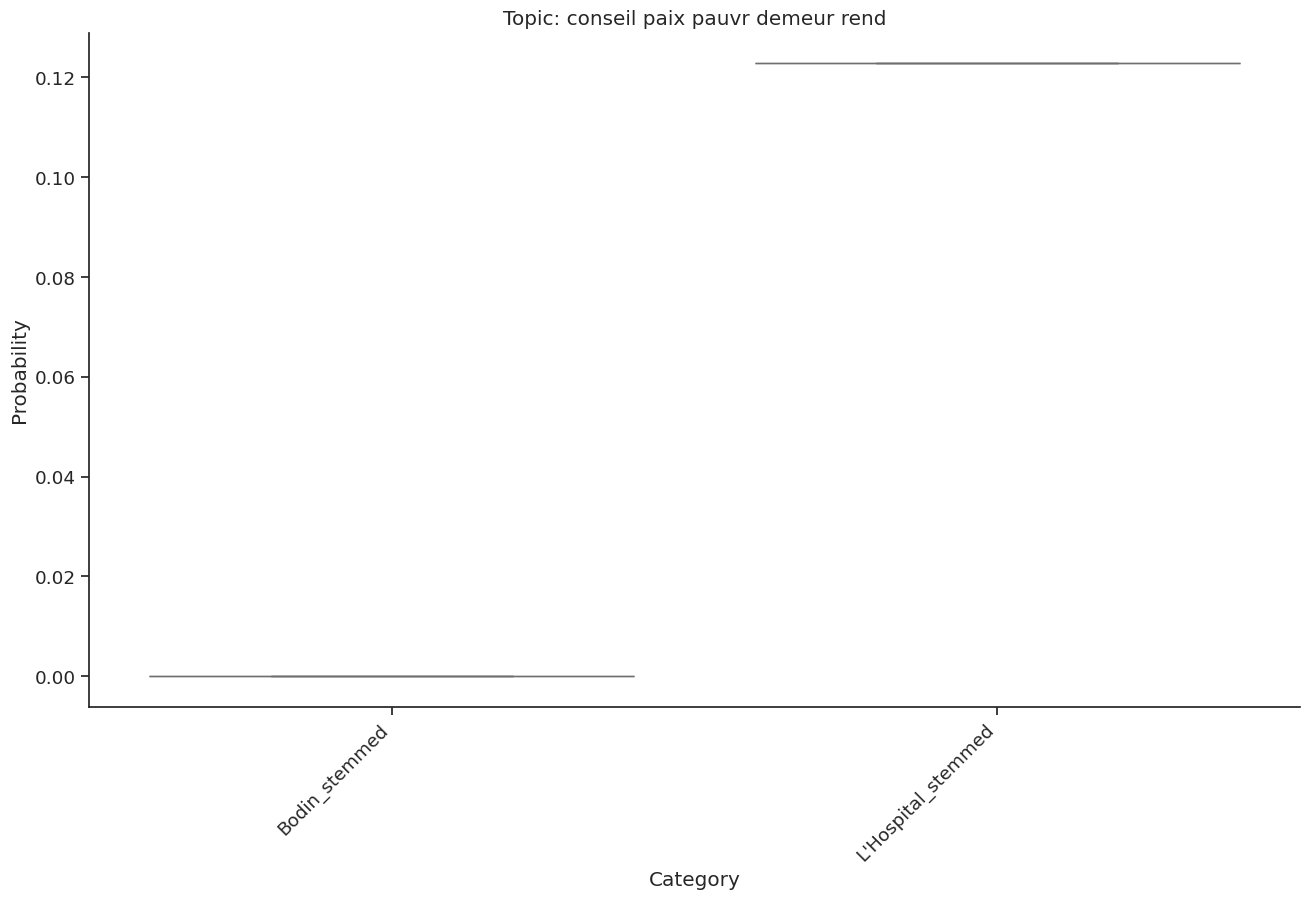

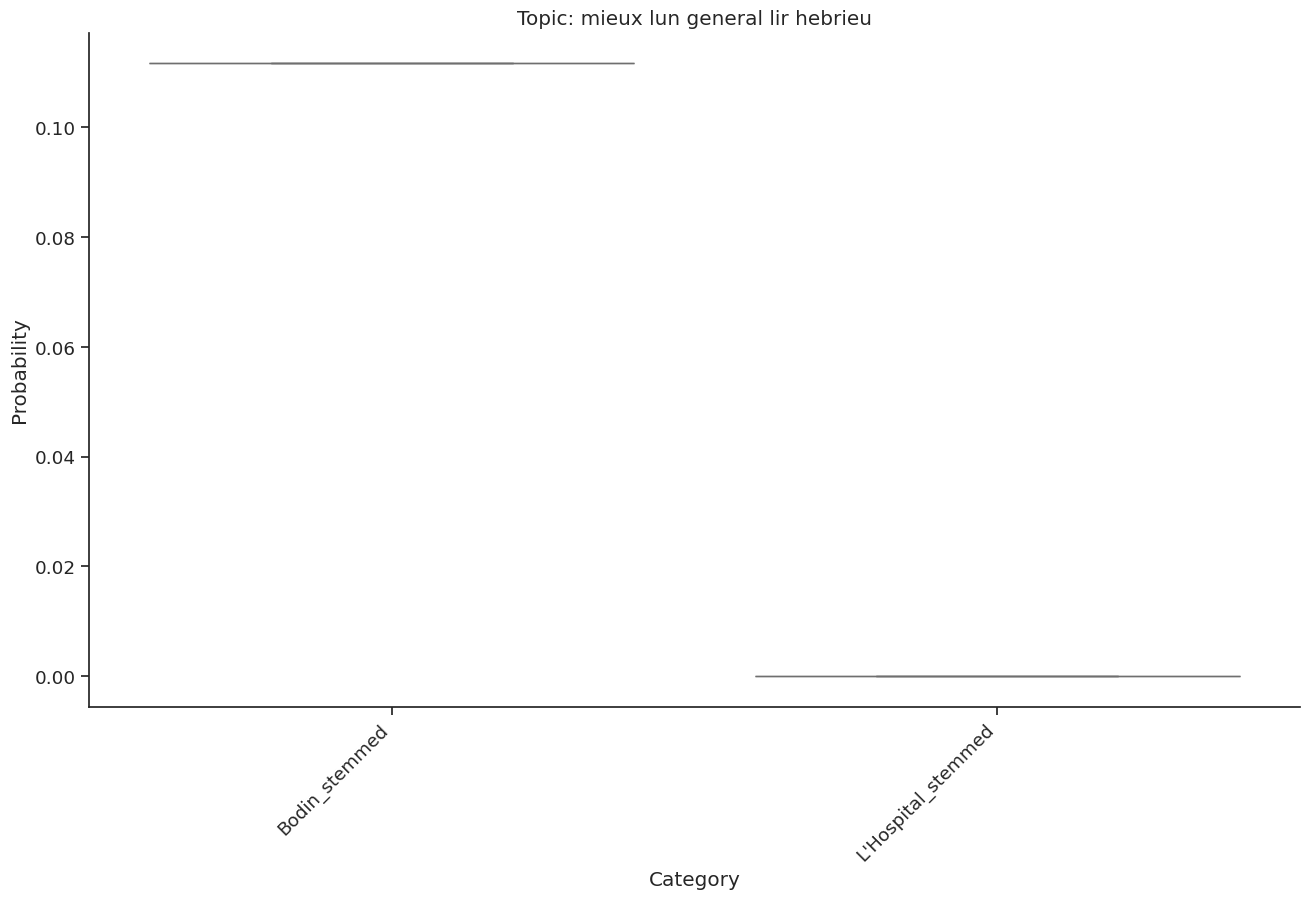

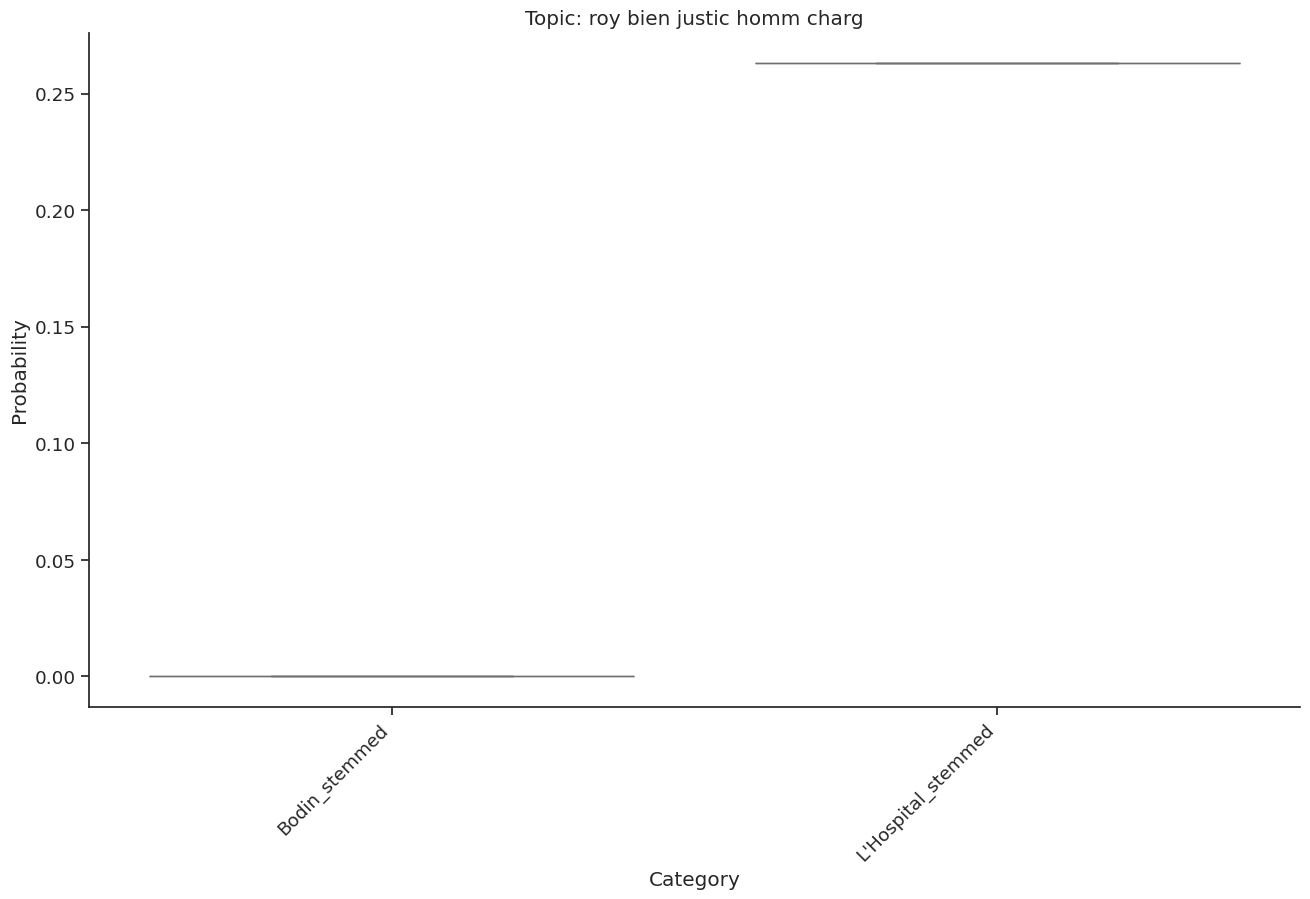

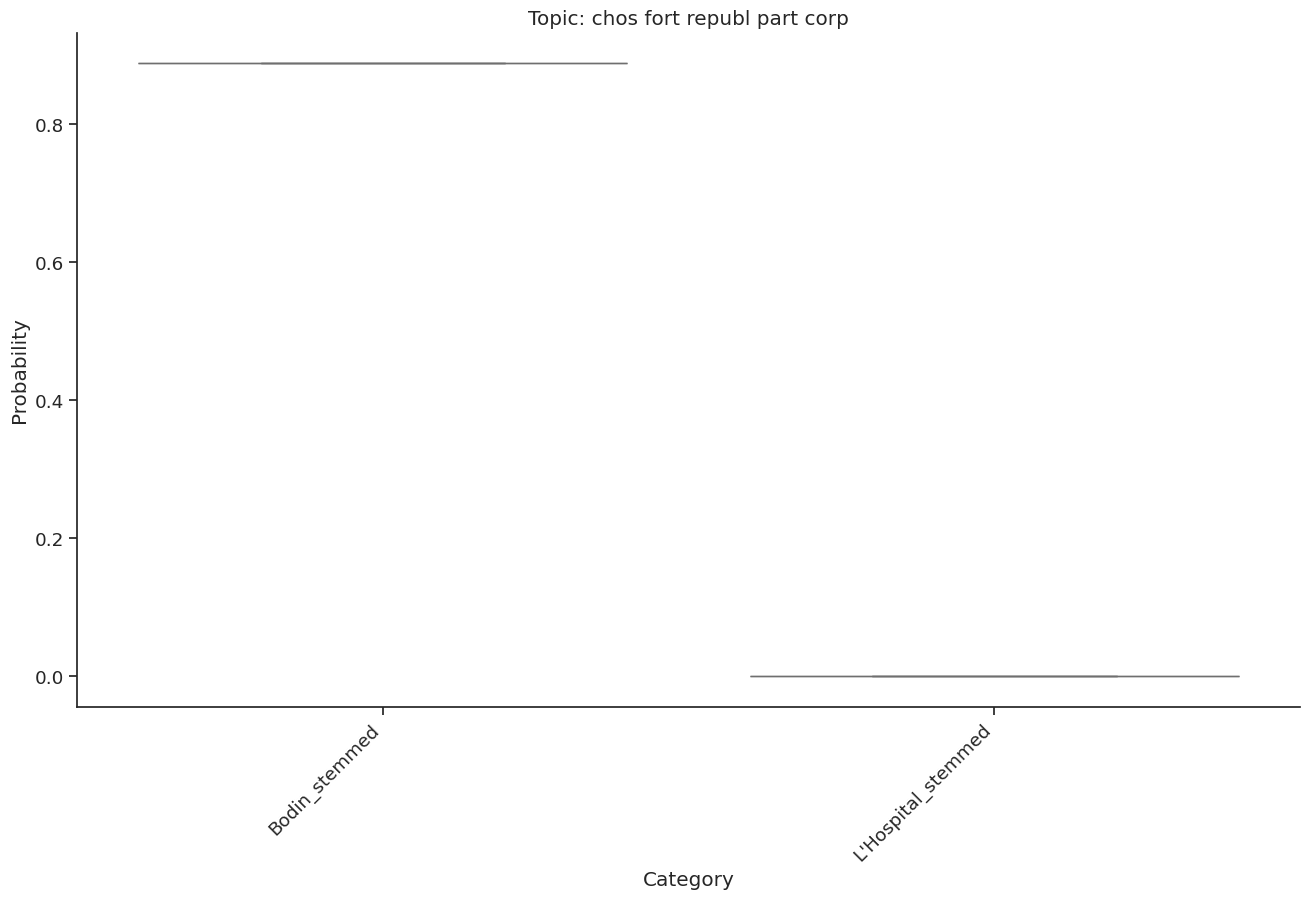

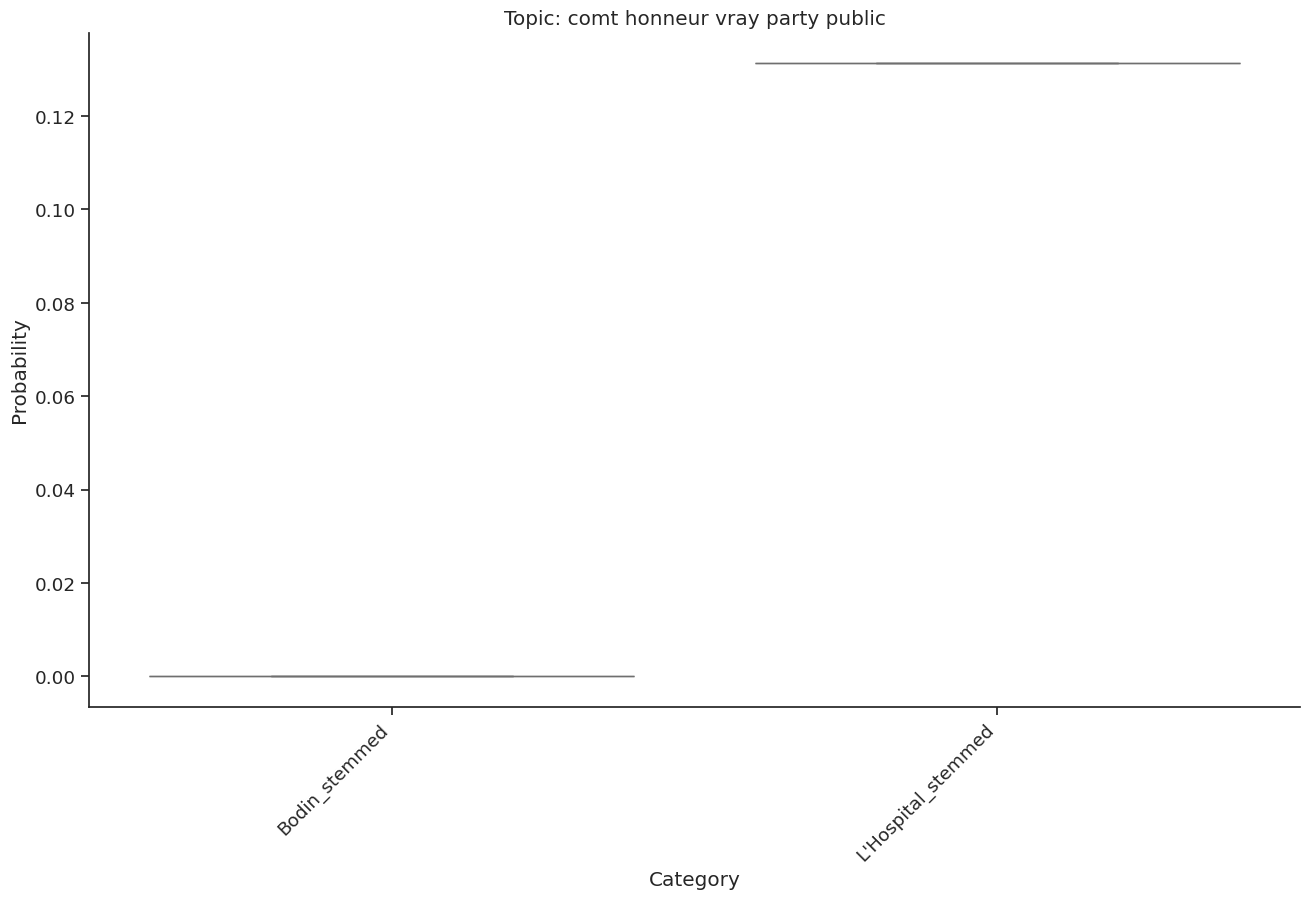

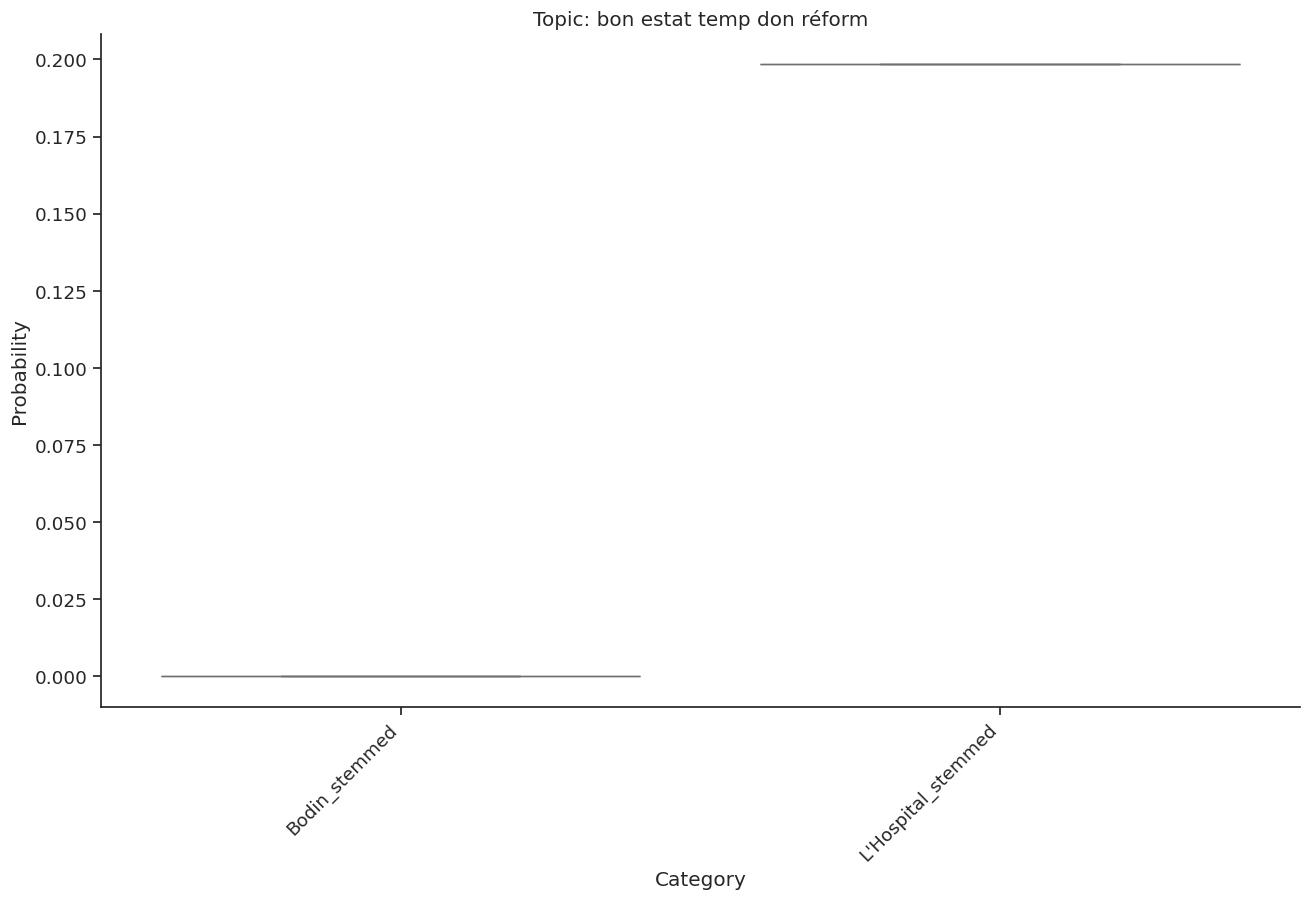

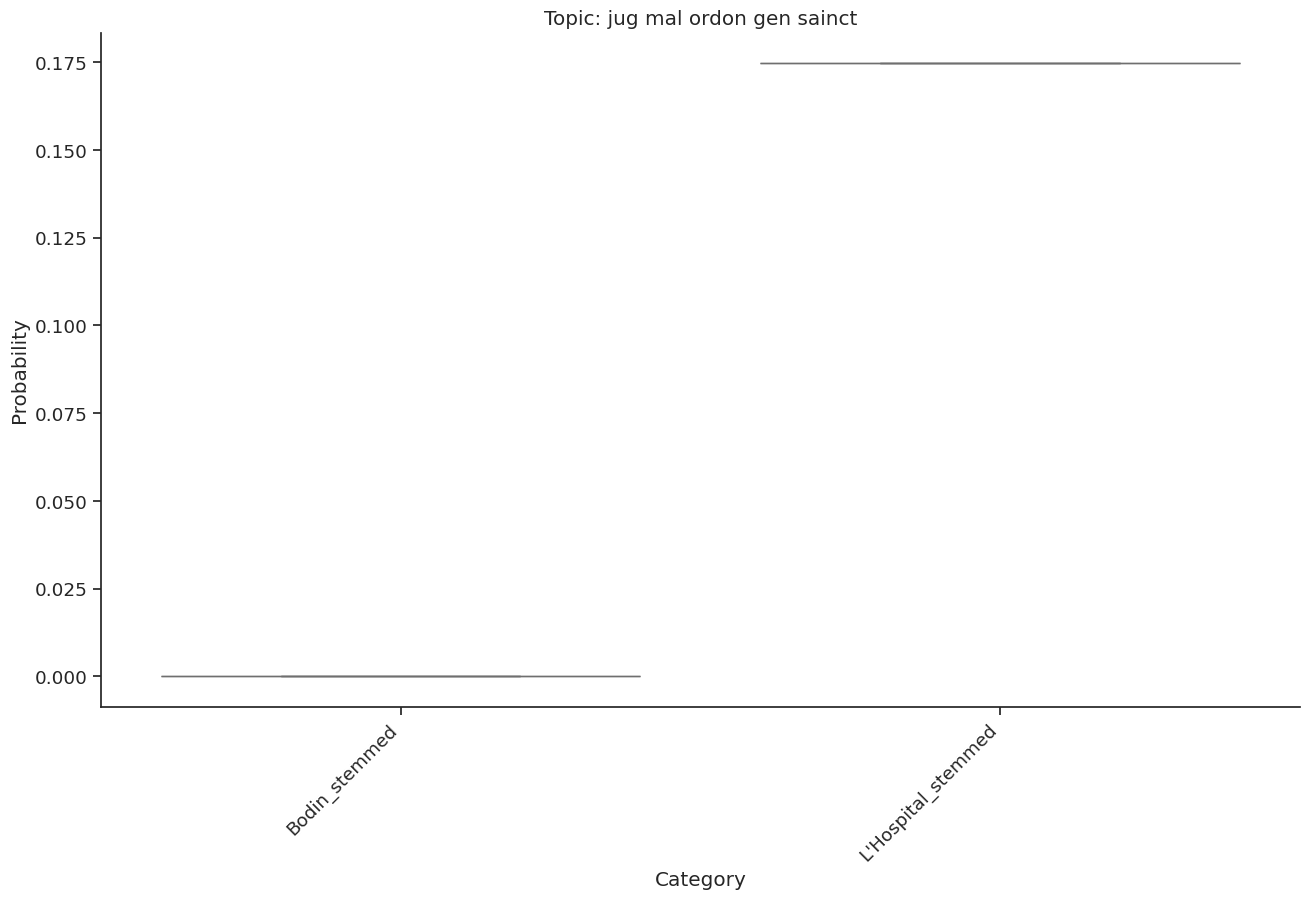

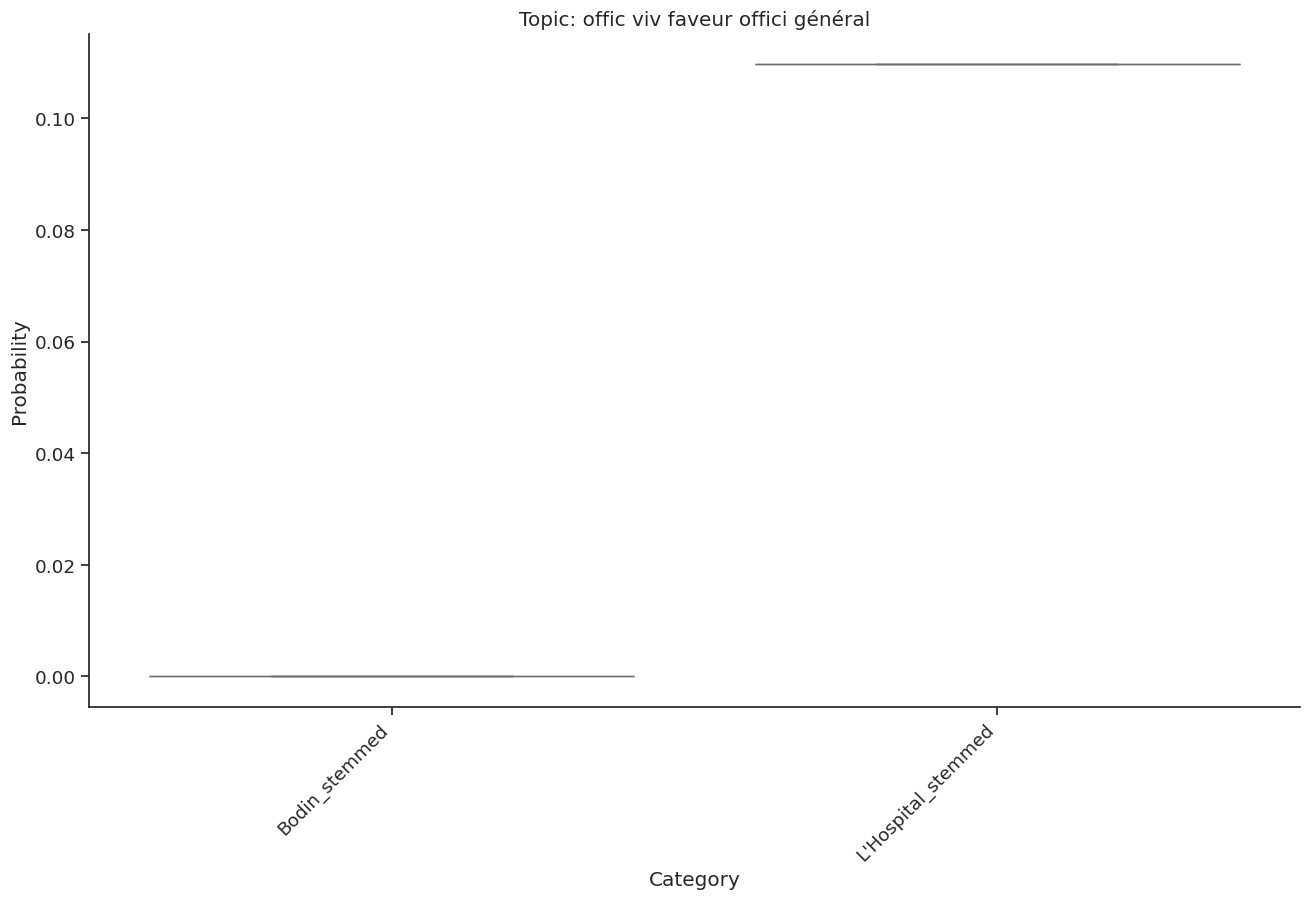

LMW boxplots saved: /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/lmw_topic_boxplots_topic_0.pdf, /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/lmw_topic_boxplots_topic_1.pdf, /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/lmw_topic_boxplots_topic_2.pdf, /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/lmw_topic_boxplots_topic_3.pdf, /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/lmw_topic_boxplots_topic_4.pdf, /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/lmw_topic_boxplots_topic_5.pdf, /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topics_8/lmw_topic_boxplots_topic_6.pdf, /workspaces/Jerusalimiec-Dissertation/Text/Corpora/Concatenated/lemmatized/August0425/topic

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import little_mallet_wrapper

# Defaults for plot dimensions and output
DEFAULT_DPI = 300
DEFAULT_DIM_INCHES = (13, 9)  # (width in inches, height in inches)
OUTPUT_DIR = None  # Will be set by user input
NUM_TOPICS = None  # Will be set by user input

# Helper function to load model results from the output directory
# Loads topic keys, document-topic distributions, and filenames used in modeling
# Returns: (list of filenames, list of topics, list of doc-topic distributions)
def _load_model_results():
    """
    Load topic keys, distributions, and filenames from the last pipeline run.
    """
    if not OUTPUT_DIR or not NUM_TOPICS:
        raise RuntimeError(
            "OUTPUT_DIR and NUM_TOPICS must be set at module level. "
            "Define them before calling plotting functions."
        )

    key_file = os.path.join(OUTPUT_DIR, f"mallet.topic_keys.{NUM_TOPICS}")
    dist_file = os.path.join(OUTPUT_DIR, f"mallet.topic_distributions.{NUM_TOPICS}")
    topics = little_mallet_wrapper.load_topic_keys(key_file)
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)

    fn_list = os.path.join(OUTPUT_DIR, "input_filenames.txt")
    with open(fn_list, "r", encoding="utf-8") as f:
        files = [line.strip() for line in f]

    return files, topics, doc_topics

# Generate and save a heatmap of topic-by-document probabilities
# Prompts user for width, calculates figure size, and saves as PDF
# Uses little_mallet_wrapper's plotting function
# Only works if OUTPUT_DIR and NUM_TOPICS are set and model results exist
def generate_heatmap():
    """
    Prompt for a desired chart width in pixels, then generate and save a
    topic-by-document heatmap. Exports only PDF + PNG.
    """
    try:
        width_px = int(input("Enter heatmap width in pixels (e.g. 1600): ").strip())
    except ValueError:
        width_px = int(DEFAULT_DIM_INCHES[0] * DEFAULT_DPI)
        print(f"Invalid input, defaulting to {width_px} px width ({DEFAULT_DPI} DPI).")

    dpi_value = DEFAULT_DPI
    aspect = DEFAULT_DIM_INCHES[1] / DEFAULT_DIM_INCHES[0]
    height_px = int(width_px * aspect)
    figsize = (width_px / dpi_value, height_px / dpi_value)

    files, topics, doc_topics = _load_model_results()
    labels = [Path(fn).stem for fn in files]

    plt.close('all')
    pdf_out = os.path.join(OUTPUT_DIR, "categories_by_topics.pdf")
    fig = little_mallet_wrapper.plot_categories_by_topics_heatmap(
        labels,
        doc_topics,
        topics,
        pdf_out,
        target_labels=labels,
        dim=figsize
    )

    if fig is None:
        fig = plt.gcf()

    fig.canvas.draw()
    plt.close(fig)

    print(f"Heatmap saved: {pdf_out}")

# Generate and save a grid of boxplots (one subplot per topic)
# Prompts user for width, calculates figure size, and saves as JPG
# Each subplot shows the distribution of topic probabilities across documents
def generate_boxplot_grid():
    """
    Prompt for a desired chart width in pixels, then draw a grid of boxplots
    (one subplot per topic) and save as a single PDF + PNG.
    """
    try:
        width_px = int(input("Enter boxplot-grid width in pixels (e.g. 1600): ").strip())
    except ValueError:
        width_px = int(DEFAULT_DIM_INCHES[0] * DEFAULT_DPI)
        print(f"Invalid input, defaulting to {width_px} px width ({DEFAULT_DPI} DPI).")

    dpi_value = DEFAULT_DPI
    aspect = DEFAULT_DIM_INCHES[1] / DEFAULT_DIM_INCHES[0]
    height_px = int(width_px * aspect)
    figsize = (width_px / dpi_value, height_px / dpi_value)

    files, topics, doc_topics = _load_model_results()
    labels = [Path(fn).stem for fn in files]
    n_topics = len(topics)

    cols = 2
    rows = (n_topics + cols - 1) // cols

    plt.close('all')
    fig, axes = plt.subplots(rows, cols,
                             figsize=figsize,
                             dpi=dpi_value,
                             sharex=True)
    axes = axes.flatten()

    for t_idx in range(n_topics):
        ax = axes[t_idx]
        data = [doc_topics[i][t_idx] for i in range(len(doc_topics))]
        ax.boxplot(data, vert=False)
        ax.set_title(f"Topic {t_idx}")
        ax.set_yticks([])

    for ax in axes[n_topics:]:
        ax.axis("off")

    fig.tight_layout()

    png_path = os.path.join(OUTPUT_DIR, "all_topic_boxplots.jpg")
    fig.savefig(png_path, dpi=dpi_value)
    plt.close(fig)

    print(f"Boxplot grid saved: {png_path}")

# Generate and save one boxplot per topic using little_mallet_wrapper's function
# Prompts user for width, calculates figure size, and saves each as a PDF
# Each plot shows the distribution of a single topic across all documents
def generate_lmw_boxplots():
    """
    Prompt for a desired chart width in pixels, then generate and save
    boxplots for each topic using lmw's plot_categories_by_topic_boxplots.
    """
    try:
        width_px = int(input("Enter LMW boxplot width in pixels (e.g. 1600): ").strip())
    except ValueError:
        width_px = int(DEFAULT_DIM_INCHES[0] * DEFAULT_DPI)
        print(f"Invalid input, defaulting to {width_px} px width ({DEFAULT_DPI} DPI).")

    dpi_value = DEFAULT_DPI
    aspect = DEFAULT_DIM_INCHES[1] / DEFAULT_DIM_INCHES[0]
    height_px = int(width_px * aspect)
    figsize = (width_px / dpi_value, height_px / dpi_value)

    files, topics, doc_topics = _load_model_results()
    labels = [Path(fn).stem for fn in files]
    n_topics = len(topics)

    plt.close('all')
    out_paths = []
    for topic_idx in range(n_topics):
        out_path = os.path.join(
            OUTPUT_DIR, f"lmw_topic_boxplots_topic_{topic_idx}.pdf"
        )
        fig = little_mallet_wrapper.plot_categories_by_topic_boxplots(
            labels,
            doc_topics,
            topics,
            topic_idx,  # <--- This is the missing argument!
            output_path=out_path,
            target_labels=None,
            dim=figsize
        )
        if fig is None:
            fig = plt.gcf()
        fig.canvas.draw()
        plt.close(fig)
        out_paths.append(out_path)

    print(f"LMW boxplots saved: {', '.join(out_paths)}")
    
# Main entry point for plotting: prompts user for output folder, number of topics, and which plots to generate
def main():
    global OUTPUT_DIR, NUM_TOPICS

    # --- MODIFIED ---
    # Helper to find all possible run directories by searching for key files.
    def find_run_dirs(root='.'):
        run_dirs = []
        for r, _, files in os.walk(root):
            if any(f.startswith("mallet.topic_keys.") for f in files):
                run_dirs.append(r)
        return run_dirs

    # Let user choose from available run directories
    print("Searching for topic model run directories...")
    possible_dirs = find_run_dirs(os.getcwd())

    if not possible_dirs:
        print("No topic model run directories found in this folder or its subfolders.")
        return

    print("Please select a run directory:")
    for i, d in enumerate(possible_dirs, 1):
        print(f"[{i}] {os.path.relpath(d)}")

    choice = -1
    while not (1 <= choice <= len(possible_dirs)):
        try:
            choice = int(input(f"Enter number (1-{len(possible_dirs)}): ").strip())
        except ValueError:
            print("Invalid input.")

    OUTPUT_DIR = possible_dirs[choice - 1]

    # Infer number of topics from the chosen directory's files
    try:
        topic_keys_file = next(f for f in os.listdir(OUTPUT_DIR) if f.startswith("mallet.topic_keys."))
        NUM_TOPICS = int(topic_keys_file.split('.')[-1])
        print(f"Successfully loaded run directory '{os.path.relpath(OUTPUT_DIR)}' with {NUM_TOPICS} topics.")
    except (StopIteration, ValueError):
        print("Could not automatically determine the number of topics from the files.")
        num_topics_str = input("Please enter the number of topics manually: ").strip()
        NUM_TOPICS = int(num_topics_str)
    # --- END MODIFIED ---

    # Prompt user to select which plots to generate
    print("\nSelect which plots to generate:")
    print("1) Heatmap (PDF)")
    print("2) Boxplot grid (JPG)")
    print("3) LMW boxplots (PDF, label-based)")
    print("Type any combination of these numbers separated by commas (e.g. 1,2,3), or 'all' for all:")
    choice = input("Your choice: ").lower()

    if "all" in choice:
        generate_heatmap()
        generate_boxplot_grid()
        generate_lmw_boxplots()
    else:
        if '1' in choice:
            generate_heatmap()
        if '2' in choice:
            generate_boxplot_grid()
        if '3' in choice:
            generate_lmw_boxplots()

if __name__ == "__main__":
    main()

In [ ]:
import os
from pathlib import Path

# Prompt the user to select a MALLET run folder (subdirectory containing 'input_filenames.txt').
# Returns the full path to the selected folder.
def choose_mallet_run(prompt="Select a MALLET run folder that contains 'input_filenames.txt' and distributions files:"):
    """
    Let the user pick a subfolder containing 'input_filenames.txt'.
    Returns the full path to that folder.
    """
    cwd = os.getcwd()
    # List all subdirectories except .ipynb_checkpoints
    subdirs = [
        d for d in os.listdir(cwd)
        if os.path.isdir(os.path.join(cwd, d)) and d != ".ipynb_checkpoints"
    ]
    if not subdirs:
        print("No subfolders found.")
        return cwd

    print(prompt)
    for i, fn in enumerate(subdirs, start=1):
        print(f"[{i}] {fn}")
    # Prompt until a valid selection is made
    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(subdirs):
                return os.path.join(cwd, subdirs[choice - 1])
        except ValueError:
            pass
        print("Invalid choice, please try again.")

# Load the list of filenames (in modeling order) and the topic distributions
# for a given MALLET run and number of topics.
def load_model_data(run_dir, num_topics):
    """
    Load the file list (input_filenames.txt) and the doc-topic distributions
    for the specified number of topics from 'run_dir'.
    Ensures that the order of files matches how they were used in modeling.
    """
    fn_list_path = os.path.join(run_dir, "input_filenames.txt")
    if not os.path.exists(fn_list_path):
        raise FileNotFoundError(f"'input_filenames.txt' not found in {run_dir}.")

    # Read the filenames in the order used for modeling
    with open(fn_list_path, "r", encoding="utf-8") as f:
        files = [line.strip() for line in f]

    dist_file = os.path.join(run_dir, f"mallet.topic_distributions.{num_topics}")
    if not os.path.exists(dist_file):
        raise FileNotFoundError(f"No doc-topic distribution file for {num_topics} topics in {run_dir}.")

    import little_mallet_wrapper
    # Load the topic distributions for each file
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)
    return files, doc_topics

# Prompt the user to select files by index, range, or 'all'.
# Returns a sorted list of selected indices (0-based).
def select_indices_in_files(file_list, group_name):
    """
    Prompt the user to pick files by:
      - 'all'
      - single indices (e.g. '3')
      - index ranges (e.g. '2-5')
      or any combination separated by commas (e.g. '1,2-4,7').

    Returns a sorted list of chosen indices (0-based).
    """
    print(f"\nSelect indices for {group_name}. Possible choices:")
    for i, f in enumerate(file_list, start=1):
        print(f"[{i}] {f}")
    user_input = input(
        f"Enter comma-separated indices or ranges, or 'all' for {group_name}: "
    ).strip().lower()

    if user_input == "all":
        return list(range(len(file_list)))

    chosen = []
    for part in user_input.split(","):
        part = part.strip()
        if "-" in part:
            # Handle range syntax "start-end"
            try:
                start_str, end_str = part.split("-")
                start = int(start_str.strip())
                end = int(end_str.strip())
                if start <= end:
                    chosen.extend(range(start - 1, end))
                else:
                    # If user reversed them accidentally, handle gracefully:
                    chosen.extend(range(end - 1, start))
            except ValueError:
                print(f"Ignoring invalid range: '{part}'")
        else:
            # Handle single numeric index
            try:
                idx = int(part) - 1
                chosen.append(idx)
            except ValueError:
                print(f"Ignoring invalid entry: '{part}'")

    # Remove duplicates and ensure ascending order
    final_indices = sorted(set(i for i in chosen if 0 <= i < len(file_list)))
    return final_indices

# Compute the average topic distance (L1 norm) between two topic distributions.
def average_topic_distance(dist_a, dist_b):
    """
    Calculate the average distance between two topic distributions
    by summing absolute differences and dividing by the number of topics.
    """
    return sum(abs(a - b) for a, b in zip(dist_a, dist_b)) / len(dist_a)

# Main logic for comparing two groups of files:
# 1. Prompt user to select two groups of files.
# 2. Prompt user to select one file from Group 1.
# 3. Compare that file to all files in Group 2 and rank by similarity.
def compare_two_groups(files, doc_topics):
    """
    1) Divide files into two groups, picking indices from 'files'.
    2) Select one file from Group 1.
    3) Compare to every file in Group 2 and rank by average topic distance.
    """
    # 1) Split into two groups
    group1_indices = select_indices_in_files(files, "Group 1")
    group2_indices = select_indices_in_files(files, "Group 2")

    # 2) Pick one file from Group 1
    print("\nWhich file from Group 1 would you like to compare?")
    for i, idx in enumerate(group1_indices, start=1):
        print(f"[{i}] {files[idx]}")
    choice = int(input("Enter the number: ")) - 1
    chosen_idx = group1_indices[choice]

    chosen_dist = doc_topics[chosen_idx]
    print(f"\nSelected file from Group 1: {files[chosen_idx]}")

    # 3) For each file in Group 2, compute average topic distance, then sort
    distances = []
    for idx in group2_indices:
        dist = average_topic_distance(chosen_dist, doc_topics[idx])
        distances.append((files[idx], dist))

    # Sort by ascending distance (most similar = smallest distance)
    distances.sort(key=lambda x: x[1])

    print("\nRanking by similarity (ascending distance):")
    for rank, (fname, distval) in enumerate(distances, start=1):
        print(f"{rank}. {fname} (distance={distval:.4f})")

# Entry point for the comparison workflow:
# 1. Prompt user to select a MALLET run folder and number of topics.
# 2. Load the files and topic distributions.
# 3. Launch the two-group comparison.
def start_comparison():
    """
    Guide the user to pick a MALLET run folder, specify the number of topics,
    then load files and doc_topic distributions and compare two groups.
    """
    run_dir = choose_mallet_run()
    num_topics = int(input("Enter the number of topics used for that run: ").strip())
    files, doc_topics = load_model_data(run_dir, num_topics)
    compare_two_groups(files, doc_topics)

# Run the comparison workflow when this cell is executed
start_comparison()